# Group Assigment 3 - GPT Models

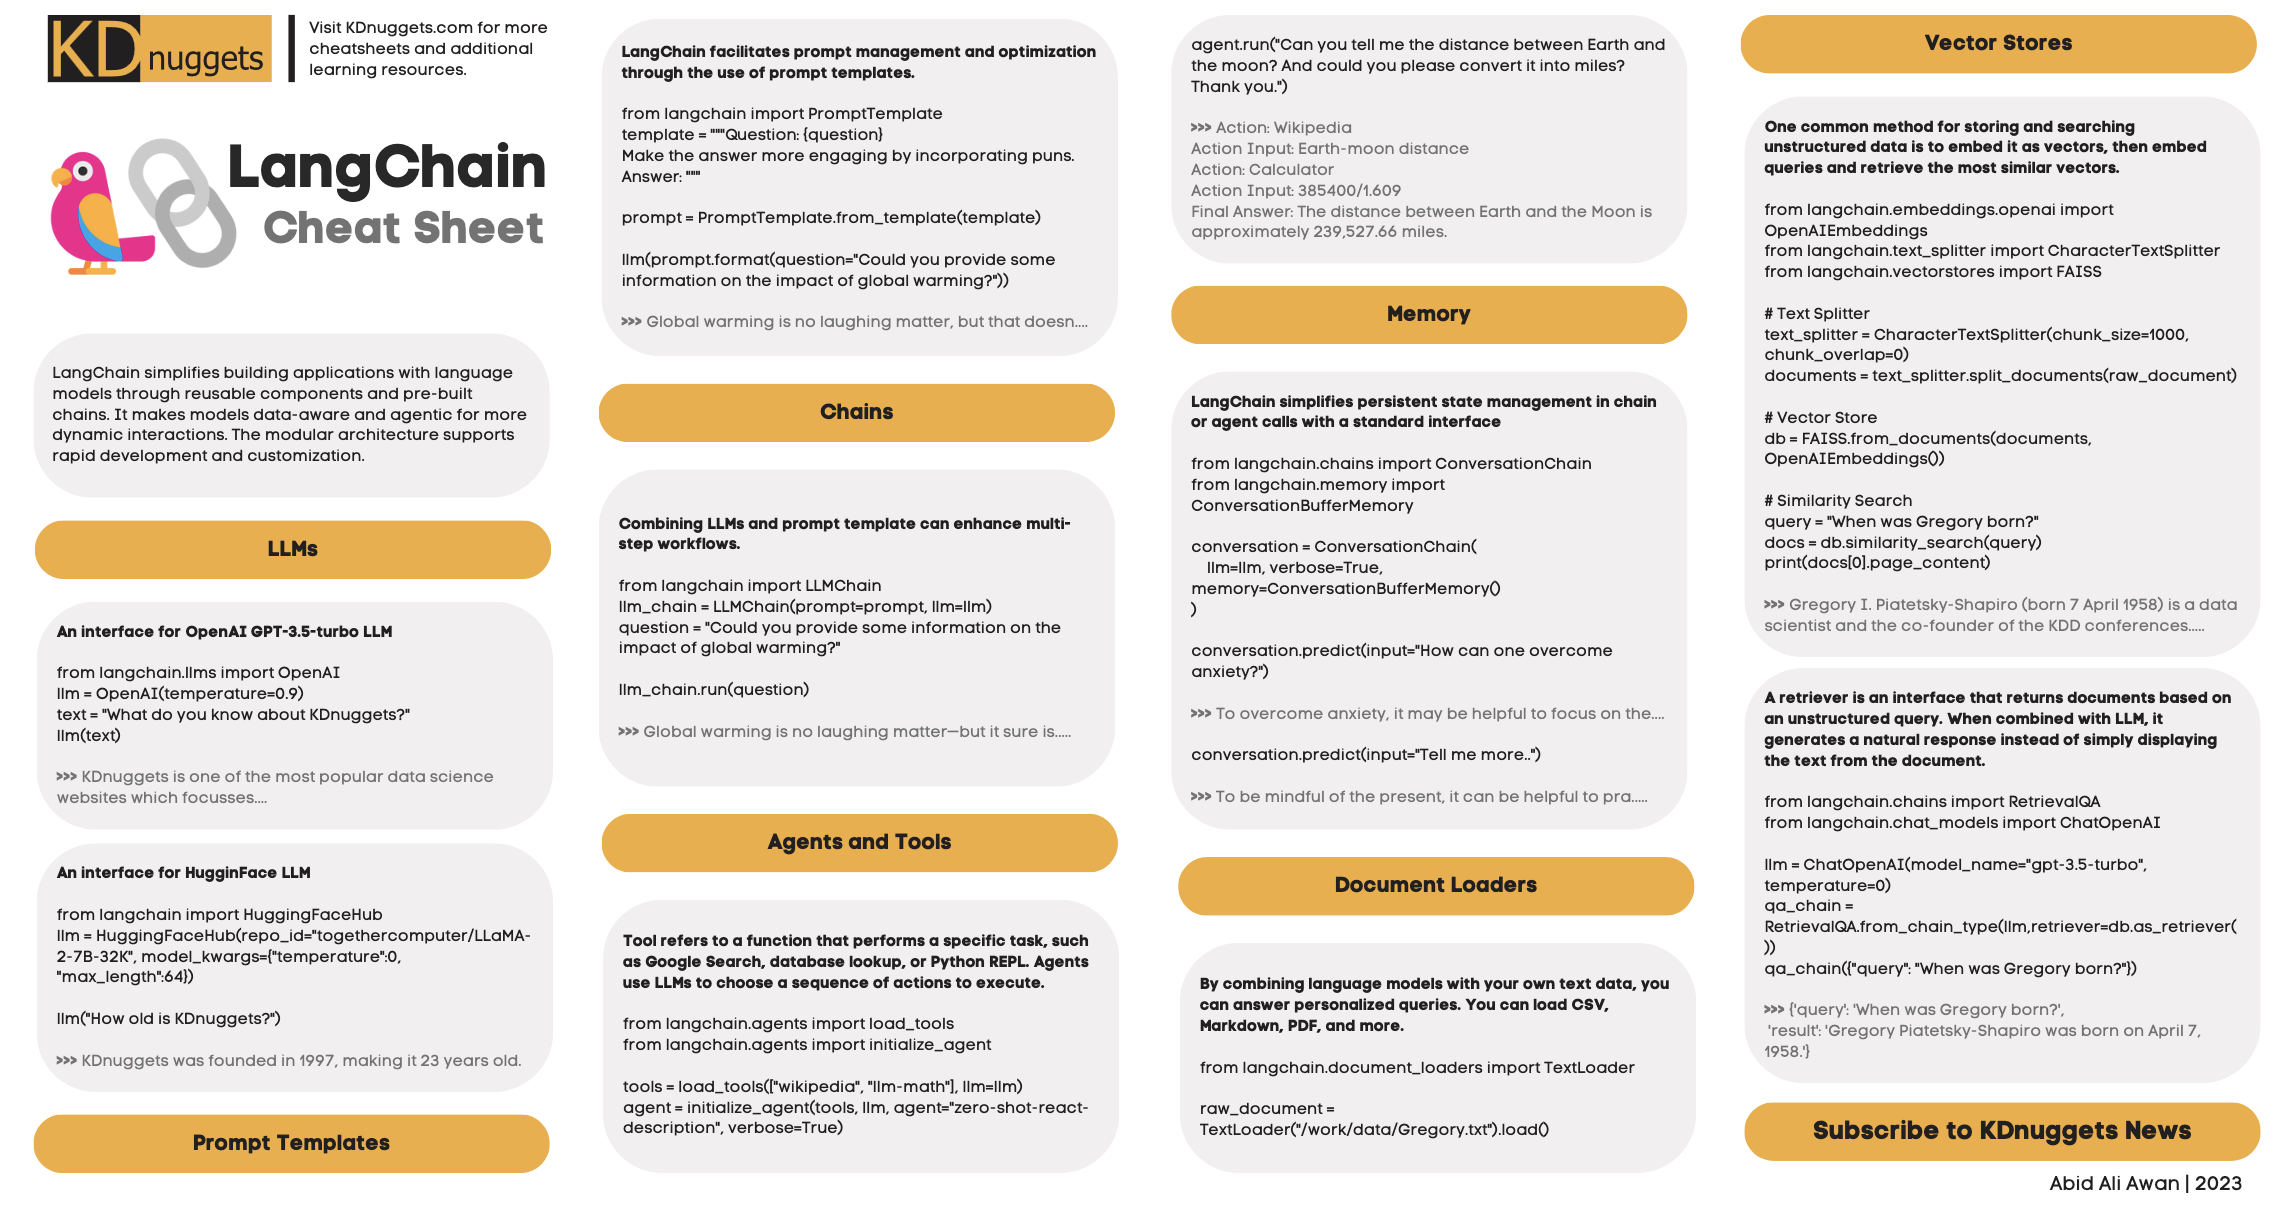




**Group Members**

*   Benjamin Ly - 20205432
*   Camilla Dyg Hannesbo - 20202923
*   Tobias Moesgård Jensen - 20231658

**Delivery**

*   Create a dedicated GitHub repository for this assignment.
*   Store all relevant materials, including the Colab notebook, in the repository.
*   Provide a README.md file with a concise description of the assignment and its components.
*   You may work individually or in groups of up to three members.
*   Submit your work by emailing a link to the repository to Hamid (hamidb@business.aau.dk).

## Objective

### Task Description

Your task is to create a system that uses RAG for extracting information from a set of documents or a document which can be either a scientific paper or report. This involves integrating a database to store vectors of document information and designing customized prompts to effectively use GPT models for generation. Here are some project ideas:



1.   Build a QA system that retrieves information from a given set of documents (or a document) to answer complex queries.
2.   Develop a tool for summarizing research papers, where the system extracts key points from a database of paper vectors.
3.   Create a recommendation engine that suggests content based on user queries and retrieved document data.
4.   
Explore other innovative applications of RAG, such as automated content generation, data analysis, or any other creative use case you can envision.



### Key  Components



*   **Database Integration:** Set up a database to store and retrieve vectors representing document information.
*   **Customized Prompts:** Design and implement prompts that effectively utilize GPT models for generation based on retrieved data.
*   **RAG Implementation:** Use Langchain to integrate retrieval-augmented generation in your system.



In [ ]:
!nvidia-smi

Sun Feb 25 04:34:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.23                 Driver Version: 551.23         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti   WDDM  |   00000000:2D:00.0  On |                  N/A |
| 35%   60C    P2             65W /  250W |    4024MiB /  11264MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import  torch
# Checking CUDA availability
print(torch.cuda.is_available())

True


In [ ]:
%time
!pip install pypdf --q
!pip install -qqq chromadb==0.4.10 --progress-bar off
!pip install -qqq langchain==0.0.299 --progress-bar off
!pip install -qqq sentence_transformers==2.2.2 --progress-bar off

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
# get a token: https://huggingface.co/docs/api-inference/quicktour#get-your-api-token

from getpass import getpass

HUGGINGFACEHUB_API_TOKEN = getpass()

··········


In [ ]:
import os

os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN

In [ ]:
# import required libraries
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import HuggingFaceHub
from langchain.vectorstores import Chroma
from langchain.chains import ConversationalRetrievalChain
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

### 1. Build a QA system that retrieves information from a given set of documents (or a document) to answer complex queries

In [ ]:
# Load the pdf file and split it into smaller chunks
loader = PyPDFLoader('StrategicChange.pdf')

docs = loader.load()
len(docs)

17

In [ ]:
# check documents
# docs

In [ ]:
# Split the documents into smaller chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(docs)
len(texts)

67

Splitting the document into chunks is required due to the limited number of tokens a LLM can look at once (4096 for Llama 2). Next, we'll use the HuggingFaceEmbeddings class to create embeddings for the chunks:

In [ ]:
# embeddings from HF
embeddings = HuggingFaceEmbeddings(
    model_name="thenlper/gte-large",
    model_kwargs={"device": "cuda"}, # change "cpu" to "cuda" when using GPU
    encode_kwargs={"normalize_embeddings": True},
)

# Generate embeddings for the first document chunk's content
query_result = embeddings.embed_query(texts[0].page_content)
print(len(query_result))

1024


In the spirit of using free tools, we're also using free embeddings hosted by HuggingFace. We'll use Chroma database to store/cache the embeddings and make it easy to search them:


In [ ]:
from langchain.vectorstores import Chroma
db = Chroma.from_documents(texts, embeddings, persist_directory="db")
results = db.similarity_search("Transformer models", k=2)
print(results[0].page_content)

DOI:10.1002/jscBUNDLING OR 
UNBUNDLINGSUBSTITUTES
OTHER 
TECHNOLOGIESEMOTIONAL
DO IT 
YOURSELF
Figure 12. Porter’s micro forces: substitutes.FORWARD 
INTEGRATIONSUPPLIER 
POWER
SIZE AND 
NUMBERRESOURCE 
SCARCITY
UNIQUE 
KNOWLEDGE
Figure 13. Porter’s micro forces: supplier power.
 10991697, 2006, 5, Downloaded from https://onlinelibrary.wiley.com/doi/10.1002/jsc.764 by Aalborg University Library, Wiley Online Library on [21/02/2024]. See the Terms and Conditions (https://onlinelibrary.wiley.com/terms-and-conditions) on Wiley Online Library for rules of use; OA articles are governed by the applicable Creative Commons License


In [ ]:
# We are using Mistral-7B for this question answering
# Use mistralai/Mistral-7B-v0.1 or mistralai/Mistral-7B-Instruct-v0.1 - if other don't work

# repo_id = "mistralai/Mistral-7B-v0.1"
repo_id = "mistralai/Mistral-7B-Instruct-v0.1"

llm = HuggingFaceHub(repo_id=repo_id, model_kwargs={"temperature":0.2, "max_new_tokens":200})

In [ ]:
from langchain.chains import RetrievalQA
from langchain import PromptTemplate

template = """
<s>[INST] <<SYS>>
Act as a company strategy consulting. Use the following information to answer the question at the end.
<</SYS>>

{context}

{question} [/INST]
"""

prompt = PromptTemplate(template=template, input_variables=["context", "question"])


qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

result = qa_chain(
    "What are the five forces in the industry analysis?"
)
print(result["result"].strip())

The five forces in the industry analysis are:

1. Threat of New Entrants
2. Bargaining Power of Suppliers
3. Bargaining Power of Buyers
4. Threat of Substitute Products or Services
5. Competitive Rivalry in the Industry


### 2. Develop a tool for summarizing research papers, where the system extracts key points from a database of paper vectors.

In [ ]:
from textwrap import fill

result = qa_chain(
    "Summarize the paper of Strategic Change"
)
print(fill(result["result"].strip(), width=80))

The paper "Strategic Change" by Porter (2006) discusses the concept of strategic
change and its importance in business. The author argues that strategic change
is a critical process that organizations must undertake to remain competitive in
today's fast-changing business environment. The paper provides a comprehensive
overview of the strategic change process, including the various stages involved
and the key factors that influence the success of strategic change initiatives.
The paper begins by defining strategic change and discussing its importance in
the context of business strategy. The author argues that strategic change is
essential for organizations to adapt to changing market conditions, new
technologies, and other external factors that can impact their competitiveness.
The paper then goes on to discuss the various stages of the strategic change
process, including the initial assessment, the development of a change strategy,
the implementation of the change, and the evaluation o